<a href="https://colab.research.google.com/github/charlesdgburns/NM_TinyRNN/blob/main/notebooks/nm_tinyrnn_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let's use this as a learning notebook about different RNN architectures.
We want to start from scratch and get an idea of how different architectures work before fitting to some data.


We the fit these to sequential behavioural decision making later.


In [36]:
## setup on google colab:

!git clone https://github.com/charlesdgburns/NM_TinyRNN.git
from pathlib import Path
CODE_DIR = Path('.')
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'


fatal: destination path 'NM_TinyRNN' already exists and is not an empty directory.


In [ ]:
# set paths not on google colab
from pathlib import Path
import os
#CODE_DIR = Path(Path(r'.'))
#os.chdir(CODE_DIR)

SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'


In [6]:
# Import packages and local code
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from NM_TinyRNN.code.models import training
from NM_TinyRNN.code.models import datasets
from NM_TinyRNN.code.models import rnns

from importlib import reload #for active development


In [45]:
# Train some models using the standard code


reload(training)
reload(datasets)

SPARSITY_LAMBDA = 0.0001
SEQUENCE_LENGTH = 150+1 # Define your desired sequence length


dataset = datasets.AB_Dataset(DATA_PATH, SEQUENCE_LENGTH)
model = rnns.TinyRNN(input_size=3, # past choice, past outcome, past forced choice
                     hidden_size=1, # hidden unit
                     out_size=2, # one-hot code for choice A, choice B
                     rnn_type='NMRNN', # GRU, LSTM, NMRNN
                sparsity_lambda = SPARSITY_LAMBDA) # Example sizes
trainer = training.Trainer(SAVE_PATH/'GRU')
trainer.fit(model,dataset)

Starting training with 4 sparsity values...
Dataset size: 28
Split sizes - Train: 22, Val: 2, Test: 4

Training with sparsity lambda = 0.01


λ=1e-02: 100%|██████████| 2000/2000 [06:51<00:00,  4.86it/s]



Training with sparsity lambda = 0.001


λ=1e-03: 100%|██████████| 2000/2000 [06:35<00:00,  5.05it/s]



Training with sparsity lambda = 0.0001


λ=1e-04: 100%|██████████| 2000/2000 [06:34<00:00,  5.07it/s]



Training with sparsity lambda = 1e-05


λ=1e-05: 100%|██████████| 2000/2000 [07:01<00:00,  4.75it/s]



Evaluating best model (λ=1e-02) on test set...
Evaluation loss: 0.628819

Training complete!
Best model (λ=1e-02) saved to: NM_TinyRNN/data/rnns/GRU
Best validation loss: 0.659589
Test loss: 0.628819
Lastly, extracting activations on full dataset


TypeError: ManualNMRNN.forward() got an unexpected keyword argument 'return_gate_activations'

In [46]:
print(dataset.subject_df)
dataset.inputs.reshape(4200,3)

     forced_choice  choice  outcome good_poke
0            False  poke_4     True    poke_4
1            False  poke_4     True    poke_4
2             True  poke_6    False    poke_4
3            False  poke_4     True    poke_4
4             True  poke_6    False    poke_4
..             ...     ...      ...       ...
453          False  poke_4    False    poke_4
454          False  poke_4     True    poke_4
455          False  poke_4     True    poke_4
456          False  poke_4    False    poke_4
457          False  poke_4     True    poke_4

[4248 rows x 4 columns]


tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        ...,
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.]])

<Axes: xlabel='epoch', ylabel='val_pred_loss'>

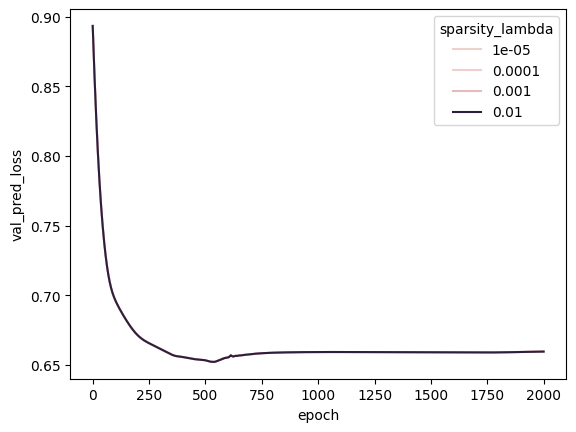

In [55]:
training_losses = pd.read_csv('./NM_TinyRNN/data/rnns/GRU/1_unit_NMRNN_training_losses.htsv', sep='\t')
import seaborn as sns

sns.lineplot(training_losses, x= 'epoch', y='val_pred_loss',hue='sparsity_lambda')

In [48]:
# Extract trial-wise data for visualisation
trials_results = pd.read_csv('./NM_TinyRNN/data/rnns/GRU/1_unit_NMRNN_training_losses.htsv', sep='\t')
trials_inputs = dataset.inputs.reshape(-1, 3).numpy().astype(int)
trials_results.loc[:, ["forced_choice","outcome", "choice"]] = trials_inputs # "forced_choice","outcome","choice"
trials_results

FileNotFoundError: [Errno 2] No such file or directory: './NM_TinyRNN/data/rnns/GRU/1_unit_NMRNN_trials_data.htsv'

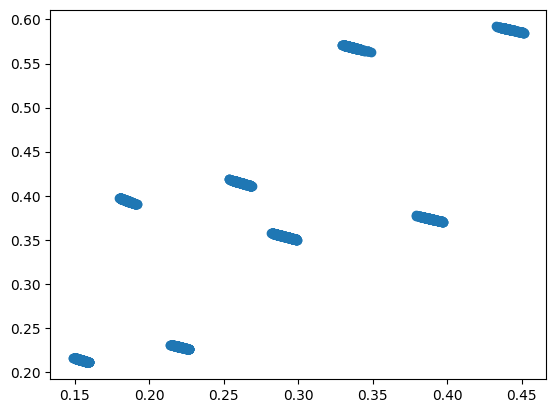

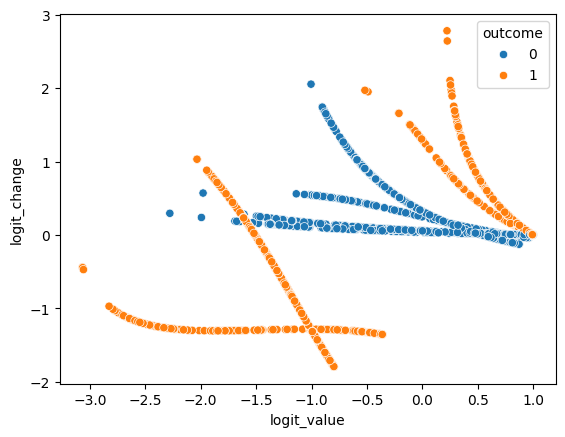

<Axes: xlabel='gate_reset_1', ylabel='gate_update_1'>

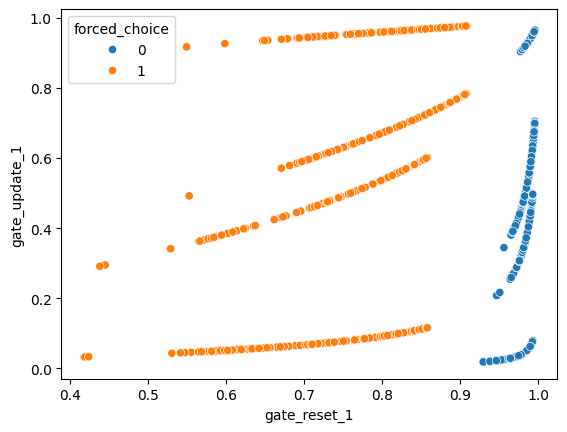

In [40]:
import seaborn as sns
trials_results['trial_type'] = trials_results['choice'] * 2 + trials_results['outcome']
sns.scatterplot(trials_results, x= 'logit_value',y='logit_change', hue='outcome')
plt.show()
sns.scatterplot(trials_results, x='gate_reset_1', y = 'gate_update_1', hue = 'forced_choice')

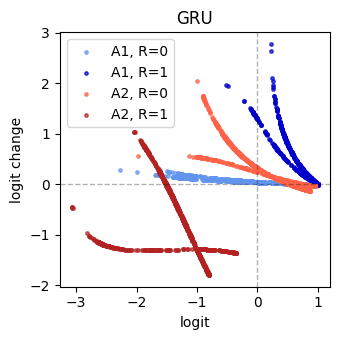

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_phase_portrait_direct(trials_results, s=6, alpha=0.7):
    """
    Plots the phase portrait directly from existing DataFrame columns:
    x = logit_value, y = logit_change.
    """
    # --- 1. Prepare data by dropping rows with no logit_change ---
    #df = trials_results.query('forced_choice == 0')
    df = trials_results
    df = df.dropna(subset=['logit_value', 'logit_change']).copy()

    # --- 2. Directly use columns to create trial types for coloring ---
    # A1,R=0 -> 0; A1,R=1 -> 1; A2,R=0 -> 2; A2,R=1 -> 3
    df['trial_type'] = df['choice'] * 2 + df['outcome']

    colors = ["cornflowerblue", "mediumblue", "tomato", "firebrick"]

    # --- 3. Plotting ---
    plt.figure(figsize=(3.5, 3.5))

    for tt in range(4):
        mask = (df['trial_type'] == tt)
        label = f'A{tt//2 + 1}, R={tt%2}' # e.g., A1, R=0
        plt.scatter(df.loc[mask, 'logit_value'], df.loc[mask, 'logit_change'],
                    c=colors[tt], s=s, alpha=alpha, label=label)

    # --- 4. Formatting ---

    # Reference lines
    plt.axhline(0, color='k', alpha=0.3, linewidth=1, linestyle='--')
    plt.axvline(0, color='k', alpha=0.3, linewidth=1, linestyle='--')

    plt.xlabel("logit")
    plt.ylabel("logit change")
    plt.title("GRU")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Usage ---
plot_phase_portrait_direct(trials_results)

In [ ]:
df = dataset.subject_df[]
df['trial_type']

In [16]:
# Extract trial-wise data for visualisation
trials_results = pd.read_csv('.data/rnns/GRU/2_unit_GRU_trials_data.htsv', sep='\t')
trials_inputs = dataset.inputs.reshape(-1, 3).numpy().astype(int)
trials_results.loc[:, ["forced_choice","outcome", "choice"]] = trials_inputs # "forced_choice","outcome","choice"
trials_results

FileNotFoundError: [Errno 2] No such file or directory: '.data/rnns/GRU/2_unit_GRU_trials_data.htsv'